<font color='blue' size = 6 > <strong> LIBRAIRIES </strong>  </font>\
\
At the beginning of all notebooks, it is necessary to load the packages that will be used to run the code. Note that some librairies might be called within other "bits" of code hidden in other files.

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import cmocean
from scipy import stats
import matplotlib.pyplot as plt
import cmocean
import cartopy
import cartopy.crs as ccrs
import datetime
%run SST_fun.ipynb

<font color='blue' size = 6 > <strong> DATA DESCRIPTION </strong>  </font>\
\
After we load the necessary libraies, the user needs to indicate the dataset and region of interest.

For this workshop, users have a choice between satellite SST products hosted by IMOS including SST and chlorophyll or data from the BlueLink ReAnalysis (BRAN) model created by CSIRO hosted on the National Computing Infrastructure servers in Canberra 

In [2]:
## This creates a random dataset for testing use only ##
lat = np.float32(np.arange(-35,-30,.1))
lon = np.float32(np.arange(100,105,.1))
time = pd.date_range("1990-01-01",periods = 365*30)
sst = abs(np.random.randn(lon.size,lat.size,time.size))*20+15+293.7
flag = (np.random.randn(lon.size,lat.size,time.size)*10).round()
data = xr.Dataset(data_vars=dict(sea_surface_temperature=(["lon","lat","time"],sst),flag=(["lon","lat","time"],flag)),coords=dict(lon=("lon",lon),lat=("lat",lat),time = ("time",time)))
data['sea_surface_temperature'] = data.sea_surface_temperature-293.7 #Kelvin to Celsius conversion


In [3]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

# Interactive panel to list details of different available products, including variables, coordinates, time step and text description.
@interact
def show_timeseries(coord = ['lon','lat','time']):
    return data[coord]
  

interactive(children=(Dropdown(description='coord', options=('lon', 'lat', 'time'), value='lon'), Output()), _…

In [4]:
### Fire cluster and load data ###
dataset = [];
box_lim = [];

In [5]:
from scipy import stats
import matplotlib.pyplot as plt

@interact
def plot_ts(longitude=(data.lon.values.min(),data.lon.values.max(),.1),latitude=(data.lat.values.min(),data.lat.values.max(),.1),time_step = ['month','year'],variable = list(data.keys())):
    ylab = variable
    freq = {'month':'M','year':'Y'}
    if time_step == 'day':
        test = data[variable]
    else:
        test = time_average(data,freq[time_step],var=ylab,ignore_inc = False)
        
    plt.figure(figsize=(15,3))
    plt.subplot(1,2,1)
    test.sel(lon=longitude,lat=latitude).plot()
    xl = test.coords['time'].values
    plt.xlim(xl.min(),xl.max())
    coef,fit,hci,lci = lin_trend(test.sel(lon=longitude,lat=latitude),'time')
    fit['linear_fit'].plot(color='red')
    plt.fill_between(lci['time'].values,lci['linear_fit'].values,hci['linear_fit'].values,alpha=0.5,color='grey')
    plt.gca().set_ylabel(ylab)
    plt.gca().set_title(time_step+'ly mean - lon:'+str(longitude)+ ' ; lat:'+str(latitude));
    
    plt.subplot(1,4,3,projection=ccrs.PlateCarree())
    ax = map(data[ylab].mean(dim='time'),[data.lon.min(),data.lon.max()],[data.lat.min(),data.lat.max()],cmap = cmocean.cm.thermal,add_colorbar = True,title='Time-Mean',cbar_kwargs={'shrink':0.7})
    plt.scatter(longitude,latitude,s=20,marker="s",color = 'black',edgecolors = 'black',zorder=3)
    

   

interactive(children=(FloatSlider(value=102.0, description='longitude', max=104.9000015258789, min=100.0), Flo…

In [5]:
# Interactive Map

@interact
def plot_ts(time = data.time.values,variable = list(data.keys())):
    ylab = variable
    map(data[ylab].sel(time=time),[data.lon.min(),data.lon.max()],[data.lat.min(),data.lat.max()],cmap = cmocean.cm.thermal,add_colorbar = True,title=time)


interactive(children=(Dropdown(description='time', options=(numpy.datetime64('1990-01-01T00:00:00.000000000'),…

<font color='blue' size = 6 > <strong> DATA ANALYSIS</strong>  </font>\
\
Now that the user has looked at main features of the dataset, we can perform some more detailed analysis, including calculating climatology, anomalies or resampling the timeseries for the whole domain or specific pixels.
The us

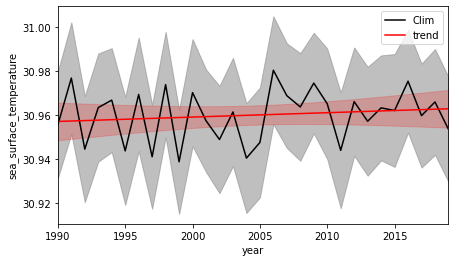

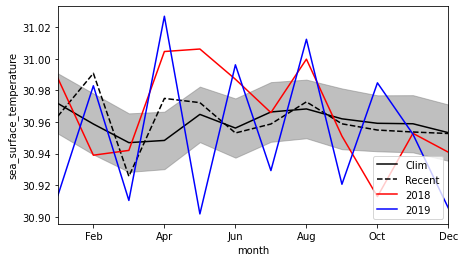

In [6]:
%matplotlib inline # This is needed to show plots in notebook but not compatible with widget extension (plots don't update).

data_bavg = data.stack(space=['lon','lat']).mean(dim='space')

clim,ax = Clim_plot(data_bavg['sea_surface_temperature'],['1990-01-01','2019-12-31'],'year')
ylab = ax.get_ylabel()

coef,fit,hci,lci = lin_trend(clim,'year')
fit['linear_fit'].plot(ax=ax,color='red',label = 'trend')
plt.fill_between(lci['year'].values,lci['linear_fit'].values,hci['linear_fit'].values,alpha=0.2,color='red')
ax.set_ylabel(ylab)
plt.legend()

clim,ax = Clim_plot(data_bavg['sea_surface_temperature'],['1990-01-01','2010-12-31'],'month',time_recent = ['2011-01-01', None],ind_yr = [2018 ,2019])


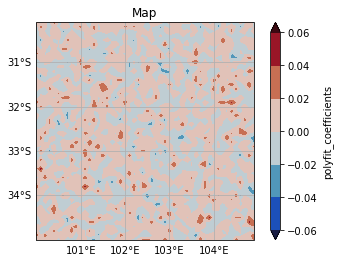

In [7]:
#Map linear trends
clim = make_clim(data['sea_surface_temperature'],time_res = 'year')
coef,fit,hci,lci= lin_trend(clim[0],'year',deg=1)
coef.isel(degree=0)['polyfit_coefficients']

map(coef.isel(degree=0)['polyfit_coefficients'],[coef.lon.min(),coef.lon.max()],[coef.lat.min(),coef.lat.max()],cmap = cmocean.cm.balance);

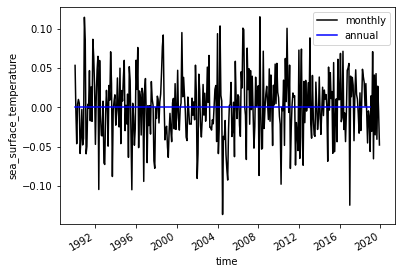

In [8]:
# Map and plot SST anomaly

# Make monthly anomalies
mn_ano = time_average(data,'M',var='sea_surface_temperature',ignore_inc = True).groupby('time.month') - make_clim(data['sea_surface_temperature'],time_res = 'month')[0]
mn_ano.stack(space=['lon','lat']).mean(dim='space').plot(label='monthly',color='black');
# Make yearly anomalies
yr_ano = time_average(data,'Y',var='sea_surface_temperature',ignore_inc = True).groupby('time.year') - make_clim(data['sea_surface_temperature'],time_res = 'year')[0]
yr_ano.stack(space=['lon','lat']).mean(dim='space').plot(label='annual',color='blue');
plt.legend()

<font color='blue' size = 6 > <strong> DATA EXTRACTION </strong>  </font>\
\
We can now extract the data in a excel format to enable users to perform further analysis. 
Note that excel spreadsheets have a limited number of rows (2^20), so a dataset that is too large will not save. \
Large spatial daily files can take 10-20mins

In [ ]:
%%time
d1 = mn_ano.to_dataframe()
d2 = yr_ano.to_dataframe()
save_excel([d1,d2],file_name="test1")

Wall time: 15min 21s


In [19]:
%%time
d3 = mn_ano.isel(time=slice(100)).to_dataframe()
save_excel([d3],file_name="test_small")

Wall time: 3min 47s
